# Here I will show how well DCT performs on spatial decorrelation using one segment of the signal. I also illustrate the effects of removing the coefficients of the highest frequencies.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import idct
import warnings
warnings.simplefilter("ignore")

s = np.load('../test_data_sintef.npy')

Text(0.5, 1.0, 'DCT basis, atoms in the column')

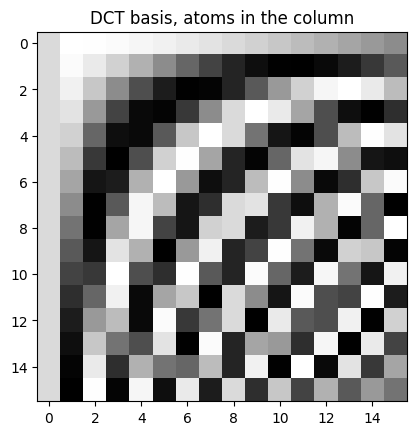

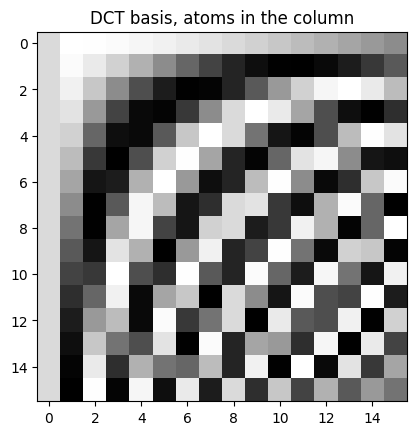

In [3]:
# generate DCT basis
pp = s.shape[1]

D = np.zeros((pp, pp))

# generate DCT basis using library
for k in range(pp):
    a = np.zeros(pp)
    a[k] = 1
    D[:, k] = idct(a, norm='ortho') # use idct on the atom

plt.figure()
plt.imshow(D, cmap='gray')
plt.title('DCT basis, atoms in the column')


# generate DCT basis using equation
DCT = np.zeros((pp, pp))

c_0 = np.sqrt(1/pp)
c_k = np.sqrt(2/pp)
for k in range(pp):
    if (k == 0):
        DCT[:, k] = [c_0*np.cos(k*np.pi*(2*n+1)/(2*pp)) for n in range(pp)] 
    else:
        DCT[:, k] = [c_k*np.cos(k*np.pi*(2*n+1)/(2*pp)) for n in range(pp)]
    DCT[:, k] = DCT[:, k] / np.linalg.norm(DCT[:, k], ord = 2) 

plt.figure()
plt.imshow(DCT, cmap='gray')
plt.title('DCT basis, atoms in the column')

We see that the two DCT basis are identical. Next we compute the coefficients

In [4]:
# this takes the DCT across the channels
def getDCT(temp, D):
    c = np.zeros((temp.shape[1], temp.shape[0]))
    
    for i in range(temp.shape[0]):
        c[:, i] = D.T@temp[i,:]

    return c

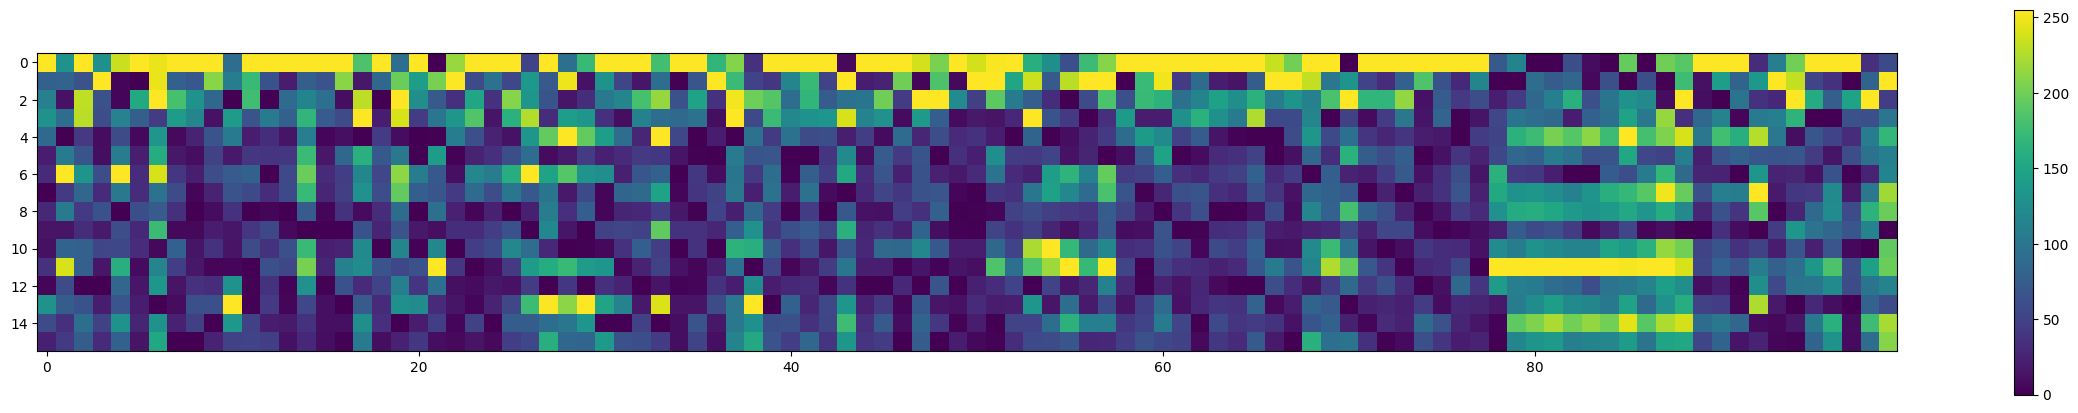

In [5]:
temp = s.astype(int) 

# function to normalize each column of the dct coefficients
def visualize_dct(c):
    for i in range(c.shape[0]):
        c[i,:] = 255* (c[i,:] - c[i,:].min()) / (c[i,:].max() - c[i,:].min())
    return c

# perform DCT
c = getDCT(temp, DCT)

# reduce the number of columns for better visualization
M = 100
c_new = np.zeros((c.shape[0], M))
step = c.shape[1] // M
for i in range(M):
    c_new[:,i] = np.mean(c[:,i*step:i*step + step], axis=1)

# visulaize the DCT coefficients
plt.figure(figsize=[30,5])
plt.imshow(visualize_dct(abs(c_new).T).T)
plt.colorbar()

We see that most of the information is contained in the lowest freqencies, but that there still is some important information in higher freqencies too. 

We then test on just the tetrode channels:

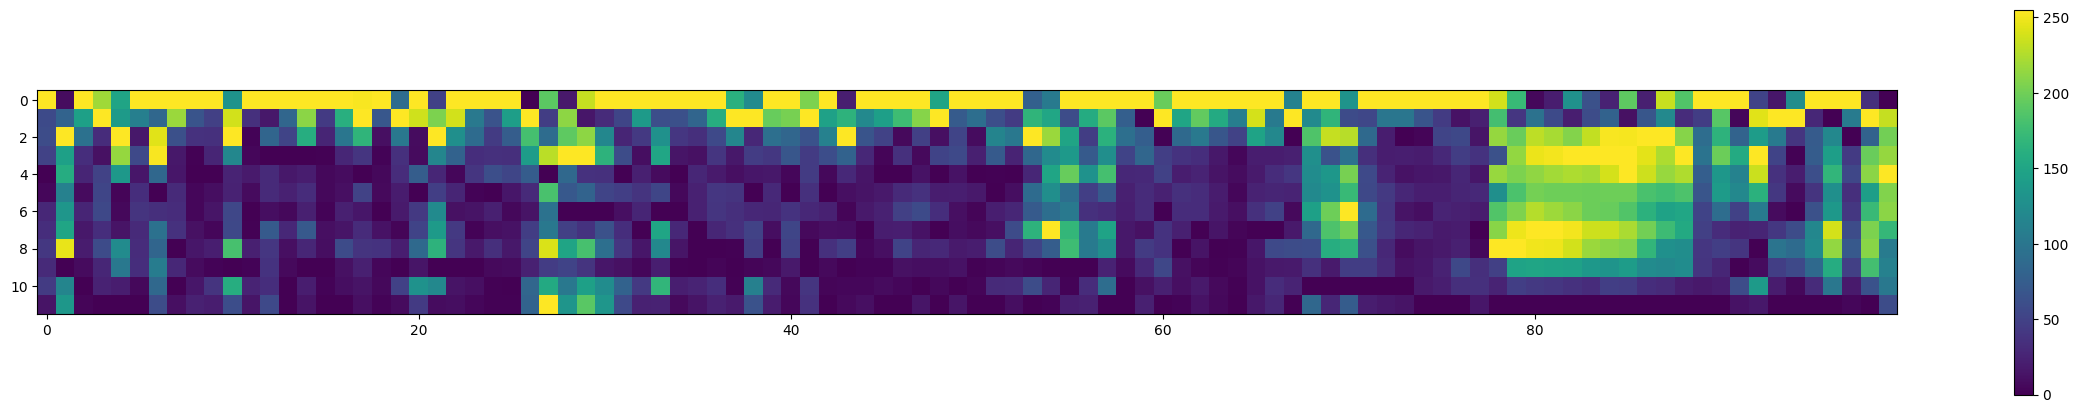

In [6]:
temp = s[:,:12].astype(int) 

# generate DCT basis
pp = temp.shape[1]

# compute new DCT basis that is 12x12
DCT = np.zeros((pp, pp))
c_0 = np.sqrt(1/pp)
c_k = np.sqrt(2/pp)
for k in range(pp):
    if (k == 0):
        DCT[:, k] = [c_0*np.cos(k*np.pi*(2*n+1)/(2*pp)) for n in range(pp)] 
    else:
        DCT[:, k] = [c_k*np.cos(k*np.pi*(2*n+1)/(2*pp)) for n in range(pp)]
    DCT[:, k] = DCT[:, k] / np.linalg.norm(DCT[:, k], ord = 2) 

# perform DCT
c = getDCT(temp, DCT)

# reduce num columns
M = 100
c_new = np.zeros((c.shape[0], M))
step = c.shape[1] // M
for i in range(M):
    c_new[:,i] = np.mean(c[:,i*step:i*step + step], axis=1)

# visulaize the DCT coefficients
plt.figure(figsize=[30,5])
plt.imshow(visualize_dct(abs(c_new).T).T)
plt.colorbar()

We see that the result is more sparse, as expected

### Threshold coefficients

Threshold to see how much loss we get from removing the highest frequency coefficients

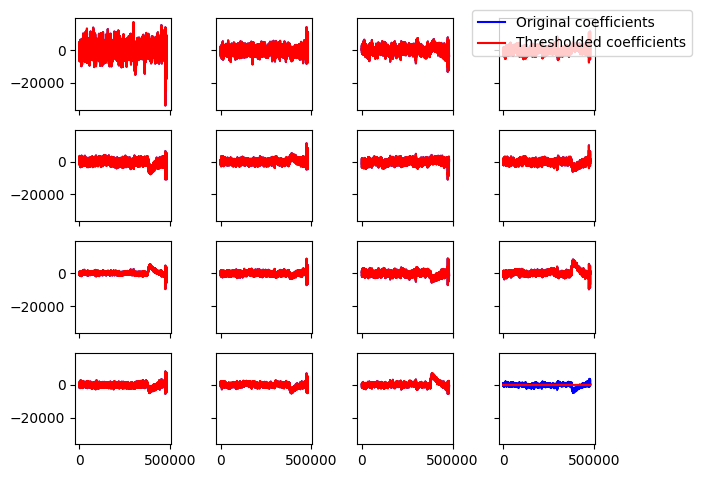

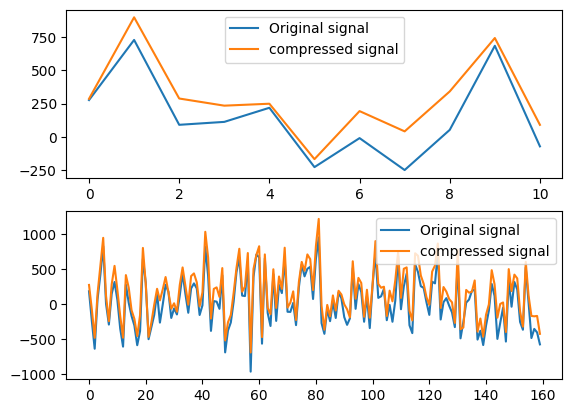

Mean SNDR across channels: 16.90 dB


In [7]:
# threshold coefficients
n_remove = 1

temp = s.astype(int) 

# threshold coefficients
c = getDCT(temp, D)

# remove the n_remove highest frequencies
c_th = c[:-n_remove, :]
c_th_full = np.pad(c_th, ((0,n_remove), (0,0)), 'constant', constant_values=(0))

# Visualize the coefficients
fig, axs = plt.subplots(4, 4, sharey=True, sharex=True)
for i in range(temp.shape[1]):
    axs.flatten()[i].plot(c[i, :], 'b')
    axs.flatten()[i].plot(c_th_full[i,:], 'r')
fig.legend(['Original coefficients', 'Thresholded coefficients'], loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout() 
plt.show()

# reconstuct signal
temp_hat = (D@c_th_full).T

# plot error
fig2, axs2 = plt.subplots(2,1)
axs2[0].plot(temp[140:151,5])
axs2[0].plot(temp_hat[140:151,5])
axs2[0].legend(['Original signal', 'compressed signal'])
axs2[1].plot(temp[40:200,5])
axs2[1].plot(temp_hat[40:200,5])
axs2[1].legend(['Original signal', 'compressed signal'])
plt.show()

SNDR = 0
for i in range(temp.shape[1]):
    P_d = np.linalg.norm(temp[:,i])
    P_error = np.linalg.norm(temp[:,i] - temp_hat[:,i])

    SNDR += 1/(temp.shape[1]) * 20*np.log10(P_d/P_error)
print(f'Mean SNDR across channels: {SNDR:.2f} dB')